Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
______________________________________

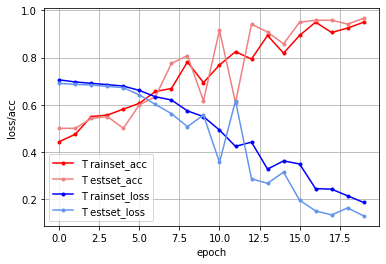

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers

import warnings
warnings.filterwarnings('ignore')

np.random.seed(3)
tf.random.set_seed(3)


# ImageDataGenerator() : 데이터의 수 늘리는 함수
train_datagen = ImageDataGenerator(rescale=1./255,         # 주어진 이미지의 크기 변경, 원본영상이 0~255 RGB값을 가지고 있으므로, 255로 나눌경우 0~1 값으로 변환되어 학습 속도 상승, 정규화 과정
                                   horizontal_flip=True,   # 수평 대칭 이미지를 50% 확률로 만들어 추가
                                   width_shift_range=0.1,  # 전체 크기의 10% 범위에서 좌우 이동
                                   height_shift_range=0.1, # 전체 크기의 10% 범위에서 위아래 이동
                                   fill_mode='nearest')    # 이미지를 축소/회전하거나 이동시 생기는 빈공간 어떻게 채울지 결정, nearest옵션 선택시 가장 비슷한 색으로 채움

# flow_from_directory() : 폴더에 저장된 데이터 호출
train_generator = train_datagen.flow_from_directory(
       '../data/22_AugmentationData/train/', 
       target_size=(150, 150),  # 이미지 크기 설정
       batch_size=5,
       class_mode='binary')     # 치매/정상 이진 분류이므로 바이너리 모드로 실행


# 데이터 부불리기는 학습셋에만 적용
# 테스트셋은 실제 정보를 그대로 유지하는 편이 과적합 위험 감소, 정규화만 진행
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       '../data/22_AugmentationData/test/',
       target_size=(150, 150),  # 이미지 크기 설정
       batch_size=5,
       class_mode='binary')     # 치매/정상 이진 분류이므로 바이너리 모드로 실행


### CNN 모델 생성
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()


### 컴파일
# sparse_categorical_crossentropy : 다중 분류 손실함수로, Dense가 2 이상이며 출력층 활성화 함수가 softmax일때 사용
    # label이 one-hot 인코딩 형태가 아닐때 사용
    # label이 one-hot 인코딩 형태 일때는 categorical_crossentropy 사용
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0002),
              metrics=['acc'])


### 실행
# fit_generator() : 대용량의 데이터를 효율적 학습시 사용, ImageDataGenerator라는 제너레이터로 이미지 담고 있는 배치로 학습시키기 때문에 fit_generator()함수 사용
    # step_per_epoch : 한 epoch에 사용한 스탭수 지정, 총 160개 훈련 샘플이 있고 배치사이즈가 5이므로 32 스텝으로 지정
    # validation_steps : 한 epoch 종료시 마다 검증할 때 사용되는 검증 스탭수 지정, 총 120개 검증 샘플이 있고 배치사이즈가 5이므로 10 스텝으로 지정
hist = model.fit_generator(train_generator,
                           steps_per_epoch=32,
                           epochs=20,
                           validation_data=test_generator,
                           validation_steps=24)


### 그래프
acc= hist.history['acc']
val_acc= hist.history['val_acc']
y_loss = hist.history['loss']
y_vloss = hist.history['val_loss']

x_len = np.arange(len(y_loss))  
plt.plot(x_len, acc, marker='.', c="red", label='T rainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='T estset_acc')
plt.plot(x_len, y_loss, marker='.', c="blue", label='T rainset_loss')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='T estset_loss')

plt.legend(loc='lower left') # 범례 안보여서 좌측 하단으로 위치 변경
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()
